# Project Part II: Predicting Housing Prices - Build Your Own Model

 

### Grading Scheme

Your grade for the project will be based on your training RMSE and test RMSE. The thresholds are as follows:

Points | 9 | 7 | 5 | 3
--- | --- | --- | --- | ---
Training RMSE | Less than 60k | [60k, 120k) | [120k, 200k) | More than 230k

Points | 9 | 7 | 5 | 3
--- | --- | --- | --- | ---
Test RMSE | Less than 65k | [65k, 130k) | [130k, 230k) | More than 230k

The top 20% of the submissions with the least testing errors will receive the additional two points


In [ ]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LassoCV, ElasticNetCV
from sklearn import ensemble

import re

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

# Extract Dataset
with zipfile.ZipFile('cook_county_contest_data.zip') as item:
    item.extractall()
    
    
### Note: we filtered the data in cook_county_contest_data, 
####so please use this dataset instead of the old one.

### Note

This notebook is specifically designed to guide you through the process of exporting your model's predictions on the test dataset for submission so you can see how your model performs.

Most of what you have done in project part I should be transferrable here. 

## Step 1. Set up all the helper functions for your `process_data_fm` function.

**Copy-paste all of the helper functions your `process_data_fm` need here in the following cell**. You **do not** have to fill out all of the functions in the cell below -- only fill out those that are actually useful to your feature engineering pipeline.

### Feature Engineerings
- OneHotEncoder
- Check skewness and normalize the dataset
- Identify features with high correlation and variation

In [ ]:
def ohe_wall_material(data):
    oh_enc = OneHotEncoder(handle_unknown='ignore')
    material_map = {1:'Frame', 2:'Masonry', 3:'Frame/Masonry', 4:'Stucco'}
    sub_data = pd.DataFrame(data['Wall Material'].map(material_map))
    oh_enc.fit([['Stucco']])
    ohe_cols = pd.DataFrame(oh_enc.transform(sub_data).todense(),
                           columns = oh_enc.get_feature_names(),
                           index = data.index
                        ).add_prefix('wall_')
    return data.join(ohe_cols)

def ohe_garage_material(data):
    oh_enc = OneHotEncoder(handle_unknown='ignore')
    material_map = {1:'Frame', 2:'Masonry', 3:'Frame/Masonry', 4:'Stucco'}
    sub_data = pd.DataFrame(data['Garage 1 Material'].map(material_map))
    oh_enc.fit([['Stucco']])
    ohe_cols = pd.DataFrame(oh_enc.transform(sub_data).todense(),
                           columns = oh_enc.get_feature_names(),
                           index = data.index
                        ).add_prefix('gar_')
    return data.join(ohe_cols)

def ohe_design_plan(data):
    oh_enc = OneHotEncoder(handle_unknown='ignore')
    design_map = {1:'architect', 2:'stock'}
    sub_data = pd.DataFrame(data['Design Plan'].map(design_map))
    oh_enc.fit([['stock']])
    ohe_cols = pd.DataFrame(oh_enc.transform(sub_data).todense(),
                           columns = oh_enc.get_feature_names(),
                           index = data.index
                        ).add_prefix('design_')
    return data.join(ohe_cols)

def ohe_basement(data):
    oh_enc = OneHotEncoder(handle_unknown='ignore')
    basement_map = {1:'Full', 2:'Slab', 3:'Partial', 4:'Crawl'}
    sub_data = pd.DataFrame(data['Basement'].map(basement_map))
    oh_enc.fit([['Full'], ['Slab'], ['Partial'], ['Crawl']])
    ohe_cols = pd.DataFrame(oh_enc.transform(sub_data).todense(),
                           columns = oh_enc.get_feature_names(),
                           index = data.index
                        ).add_prefix('basement_')
    return data.join(ohe_cols)

def ohe_central_heat(data):
    oh_enc = OneHotEncoder(handle_unknown='ignore')
    basement_map = {1:'Air', 2:'Water', 3:'Electric', 4:'Other'}
    sub_data = pd.DataFrame(data['Central Heating'].map(basement_map))
    oh_enc.fit([['Air'], ['Water'], ['Electric'], ['Other']])
    ohe_cols = pd.DataFrame(oh_enc.transform(sub_data).todense(),
                           columns = oh_enc.get_feature_names(),
                           index = data.index
                        ).add_prefix('heat_')
    return data.join(ohe_cols)

In [ ]:
def drop_columns(df, columns):
    return df.drop(columns=columns)

#### Identify Features

In [ ]:
def find_bedrooms(description):
    lst = re.findall(r'(\d+) of which are bedrooms', description)
    if bool(lst):
        return int(lst[0])
    else:
        return 0

def find_rooms(description):
    lst = re.findall(r'a total of (\d+) rooms', description)
    if bool(lst):
        return int(lst[0])
    else:
        return 0

def add_kinds_room(df):
    data = df.copy()
    # add rooms, bedrooms
    data['Bedrooms'] = data['Description'].apply(find_bedrooms)
    data['Rooms'] = data['Description'].apply(find_rooms)
    return data

def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def clear_zero(df):
    data = df.copy()
    grouped_data = data.groupby(['Town Code'])
    data['Fixed Estimate (Building)'] = data['Estimate (Building)']/data['Building Square Feet']
    data['Fixed Estimate (Land)'] = data['Estimate (Land)']/data['Land Square Feet']
    data['Fixed Estimate (Building)'] = grouped_data['Fixed Estimate (Building)'].transform(lambda x: x.replace(0, x.median()))
    data['Fixed Estimate (Building)'] = data['Fixed Estimate (Building)']*data['Building Square Feet']
    data['Fixed Estimate (Land)'] = grouped_data['Fixed Estimate (Land)'].transform(lambda x: x.replace(0, x.median()))
    data['Fixed Estimate (Land)'] = data['Fixed Estimate (Land)']*data['Land Square Feet']
    data['Fixed Estimate All'] = data['Fixed Estimate (Land)'] + data['Fixed Estimate (Building)']
    return data

def total_estimate(df):
    data = df.copy()
    data['Estimate All'] = data['Estimate (Building)'] + data['Estimate (Land)']
    return data

#### Normalization and Log

In [ ]:
def Normalization(df, columns):
    data = df.copy()
    scaler = RobustScaler()
    data[columns] = scaler.fit_transform(data[columns])
    return data

def add_log_columns(df, *columns):
    data = df.copy()
    for name in columns:
        new_name = "Log " + name
        data[new_name] = np.log(data[name])
    return data

def drop_columns(df, columns):
    return df.drop(columns=columns)

#### Generalized Pipeline Function

In [ ]:
def process_data_gm(data, pipeline_functions):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    return data

## Step 2. Setup your `process_data_fm` function

**Create your implementation of `process_data_fm` from into the following cell.**

Here are a few additional things **you should check and change to make sure your `process_data_fm` function satisfies**:
- Unlike part 1, we will not be expecting your `process_data_fm` function to return both the design matrix `X` and the observed target vector `y`; your function should now **only return X**.


In [ ]:
# Please include all of your feature engineering process inside this function.
# Do not modify the parameters of the function below. 
# Note that data will no longer have the column Sale Price in it directly, so plan your feature engineering process around that.
def process_data_fm(data):
    # Replace the following line with your own feature engineering pipeline
    X = data.copy()
    log_columns = [
                "Building Square Feet", 
                "Rooms", "Bedrooms", 
                "Fixed Estimate All",
                "Fixed Estimate (Land)", 
                "Fixed Estimate (Building)", 
                "Latitude",
                "Property Class"
            ]
    drop_cols = [
        'Central Heating',
        'Basement',
        'Design Plan',
        'Garage 1 Material',
    ]
    pipeline = [
        (add_kinds_room, False, False),
        (ohe_basement, False, False),
        (ohe_central_heat, False, False),
        (ohe_design_plan, False, False),
        (ohe_garage_material, False, False),
        (ohe_wall_material, False, False),
        (drop_columns, [drop_cols], False),
        (total_estimate, False, False),
        (clear_zero, False, False),        
        (add_log_columns, log_columns, False),
    ]
    
    for function, arguments, keyword_arguments in pipeline:
        if keyword_arguments and (not arguments):
            X = X.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            X = X.pipe(function, *arguments)
        else:
            X = X.pipe(function)
    return X

In [ ]:
from sklearn.linear_model import RidgeCV
import xgboost as xgb

## Step 3. Train your model

Run the following cell to import the new set of training data to fit your model on. **You can use any regression model, the following is just an example** If your `process_data_fm` satisfies all the specified requirements, the cell should run without any error.

**As usual**, your model will predict the log-transformed sale price, and our grading will transform your predictions back to the normal vlaues.

### Data Preparation

In [ ]:
a = pd.read_csv('cook_county_contest_train.csv', index_col='Unnamed: 0')

In [ ]:
y_train = np.log(a['Sale Price'])
piped_a = process_data_fm(a.drop(columns=['Sale Price']))

### Data Visualization

In [ ]:
visual_data = process_data_fm(a)
pre_corrmat =visual_data.corr()
important_cols = pre_corrmat.nlargest(12, 'Sale Price').index
print(important_cols)

Index(['Sale Price', 'Log Fixed Estimate All', 'Fixed Estimate (Building)',
       'Fixed Estimate All', 'Log Fixed Estimate (Building)', 'Estimate All',
       'Estimate (Building)', 'Log Fixed Estimate (Land)',
       'Building Square Feet', 'Log Building Square Feet',
       'Fixed Estimate (Land)', 'Estimate (Land)'],
      dtype='object')


<AxesSubplot:>

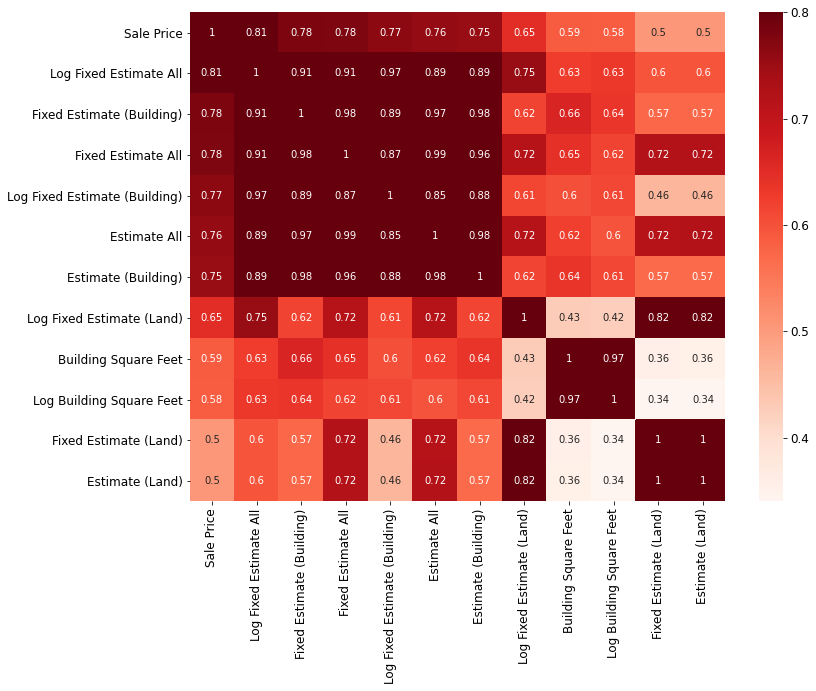

In [ ]:
sns.heatmap(data=visual_data[important_cols].corr(), vmax=.8, cmap="Reds", annot=True, annot_kws={"size":10})

#### Fixed Estimate All

<AxesSubplot:>

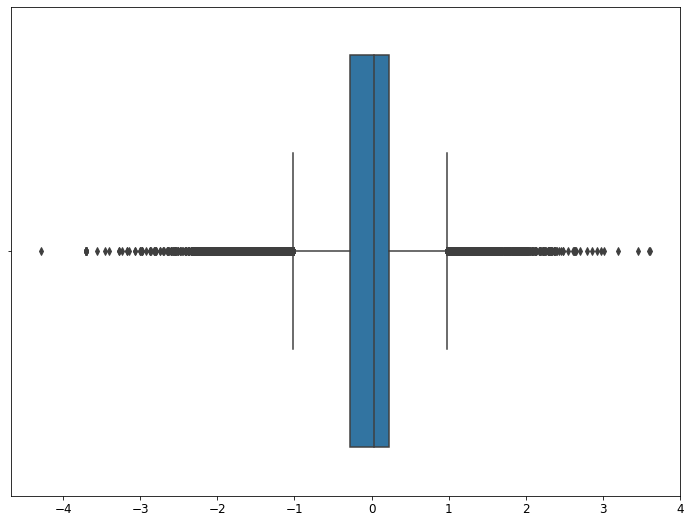

In [ ]:
sns.boxplot(y_train - piped_a['Log Fixed Estimate All'])

#### Skewness

In [ ]:
np.abs(np.abs(piped_a.skew(axis=0)) - np.abs(y_train.skew())).sort_values()

basement_x0_Full                0.021231
Log Building Square Feet        0.041875
design_x0_stock                 0.078869
Bedrooms                        0.103265
Cathedral Ceiling               0.160282
                                 ...    
Other Improvements             85.198856
Lot Size                       93.714585
Land Square Feet               93.714585
Number of Commercial Units     94.843641
Apartments                    176.801503
Length: 80, dtype: float64

### Model Selection

### Ridge

In [ ]:
lm = RidgeCV(alphas=[0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0])
lm_cols = [
    'Log Fixed Estimate All',
    'Fixed Estimate All',
    'Log Building Square Feet',
    'design_x0_stock',
    'basement_x0_Partial',
    'Log Bedrooms',
] 


X_train = Normalization(piped_a[lm_cols], lm_cols)
Xr, Xe, yr, ye = train_test_split(X_train, y_train, test_size = 0.2)
lm.fit(Xr[lm_cols], yr)
lm.alpha_

10.0

In [ ]:
lm.coef_

array([ 1.03905761, -0.18543519,  0.02064792,  0.02168482,  0.02479288,
        0.00459488])

In [ ]:
lm.intercept_

12.180555272488734

In [ ]:
from sklearn import metrics
Err_r = np.sqrt(metrics.mean_squared_error(np.exp(lm.predict(Xr[lm_cols])), np.exp(yr)))
Err_e = np.sqrt(metrics.mean_squared_error(np.exp(lm.predict(Xe[lm_cols])), np.exp(ye)))
Err_r, Err_e

(87871.2585588557, 86217.44584104947)

In [ ]:
lm.fit(X_train[lm_cols], y_train)
y_pred = lm.predict(X_train[lm_cols])
Err_o = np.sqrt(metrics.mean_squared_error(np.exp(y_pred), np.exp(y_train)))
Err_o

87547.23721398806

##### Residual Plot

Text(0, 0.5, 'Log Residual')

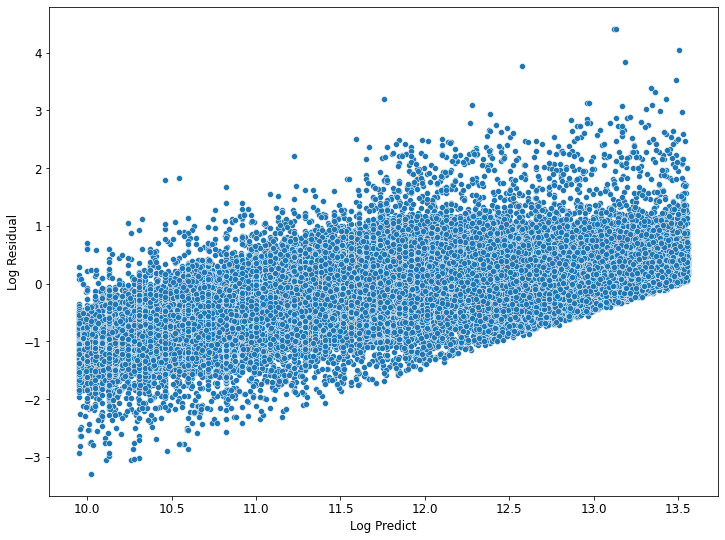

In [ ]:
sns.scatterplot(y_train, y_train-y_pred)
plt.xlabel('Log Predict')
plt.ylabel('Log Residual')

### Xgboost

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

xgb_X_train = piped_a.select_dtypes(include=[np.number])
X_tr, X_te, y_tr, y_te = train_test_split(xgb_X_train, y_train, test_size = 0.1)
X_tr_xgb, X_te_xgb, y_tr_xgb, y_te_xgb = train_test_split(X_tr, y_tr, test_size = 0.2)

#### Xgboost Model Training Code

In [ ]:
xgb_model = xgb.XGBRegressor(
    learning_rate=0.2,
    objective='reg:squarederror',
    booster='dart',
    max_depth=10,
    reg_alpha=8,
    reg_lambda=2,
    gamma=0.1,
    n_estimators=120
)
# 0.2, 10, 3, 0.2, 120: 58 65
# 0.1, 16, 4, 0.2, 200: 61 66
# 0.1, 16, 4, 0.2, 300: 59.7 65.5
# 0.1, 12, 4, 0.2, 300: 58.6 65.3
###You can use other models
xgb_model.fit(X_tr_xgb, y_tr_xgb, eval_metric='rmse', eval_set=[(X_tr_xgb, y_tr_xgb), (X_te_xgb, y_te_xgb)], 
          early_stopping_rounds=20, 
          verbose=1);
print('Stop!')

[0]	validation_0-rmse:9.33556	validation_1-rmse:9.33951
[1]	validation_0-rmse:7.47343	validation_1-rmse:7.47621
[2]	validation_0-rmse:5.98458	validation_1-rmse:5.98649
[3]	validation_0-rmse:4.79448	validation_1-rmse:4.79559
[4]	validation_0-rmse:3.84366	validation_1-rmse:3.84422
[5]	validation_0-rmse:3.08458	validation_1-rmse:3.08494
[6]	validation_0-rmse:2.47939	validation_1-rmse:2.47944
[7]	validation_0-rmse:1.99754	validation_1-rmse:1.99724
[8]	validation_0-rmse:1.61495	validation_1-rmse:1.61456
[9]	validation_0-rmse:1.31229	validation_1-rmse:1.31209
[10]	validation_0-rmse:1.07415	validation_1-rmse:1.07436
[11]	validation_0-rmse:0.88791	validation_1-rmse:0.88868
[12]	validation_0-rmse:0.74420	validation_1-rmse:0.74569
[13]	validation_0-rmse:0.63492	validation_1-rmse:0.63731
[14]	validation_0-rmse:0.55248	validation_1-rmse:0.55594
[15]	validation_0-rmse:0.49210	validation_1-rmse:0.49680
[16]	validation_0-rmse:0.44771	validation_1-rmse:0.45413
[17]	validation_0-rmse:0.41619	validation

#### Here Only Use the Saved Model

In [ ]:
from sklearn import metrics 

In [ ]:
# xgb_model = xgb.XGBRegressor()
# xgb_model.load_model('my_xgb.json')

In [ ]:
xgb_pred_tr = xgb_model.predict(X_tr)
xgb_pred_te = xgb_model.predict(X_te)
xgb_pred_all = xgb_model.predict(xgb_X_train)

In [ ]:
xgb_Err_tr = np.sqrt(metrics.mean_squared_error(np.exp(xgb_pred_tr), np.exp(y_tr)))
xgb_Err_te = np.sqrt(metrics.mean_squared_error(np.exp(xgb_pred_te), np.exp(y_te)))

In [ ]:
xgb_Err_tr, xgb_Err_te

(58746.63912374003, 65865.234267722)

In [ ]:
xgb_Err_o = np.sqrt(metrics.mean_squared_error(np.exp(xgb_pred_all), np.exp(y_train)))
xgb_Err_o

59496.86247236579

Text(0, 0.5, 'Log Residual')

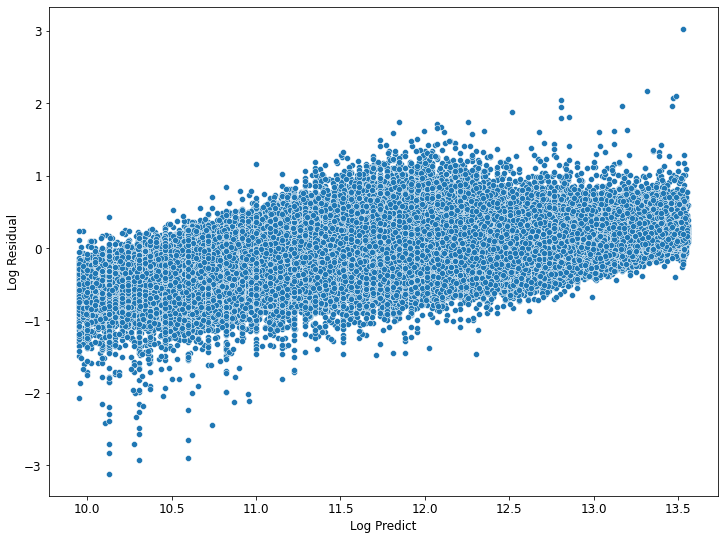

In [ ]:
sns.scatterplot(y_train, y_train-xgb_pred_all)
plt.xlabel('Log Predict')
plt.ylabel('Log Residual')

#### Xgboost + Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
gm = RandomForestRegressor(
    n_estimators=120,
    max_features='log2',
    min_samples_leaf=20,
    random_state=37,
    oob_score=True,
    bootstrap=True,
    verbose=1,
)

 
# param_grid = {
    # 'max_features': [0.3, 0.4, 0.5, 'sqrt'],
    # 'n_estimators': [100, 150, 200, 250],
    # 'min_samples_leaf': [50, 25, 20, 10]
    
# }
# gm = GridSearchCV(rf, param_grid,  cv=5, scoring='neg_mean_squared_error')

In [ ]:
gm.fit(X_tr, y_tr-xgb_pred_tr)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.5min finished


RandomForestRegressor(max_features='log2', min_samples_leaf=20,
                      n_estimators=120, oob_score=True, random_state=37,
                      verbose=1)

In [ ]:
for_Err_r = np.sqrt(metrics.mean_squared_error(np.exp(gm.predict(X_tr) + xgb_pred_tr), np.exp(y_tr)))
for_Err_e = np.sqrt(metrics.mean_squared_error(np.exp(gm.predict(X_te) + xgb_pred_te), np.exp(y_te)))
for_Err_r, for_Err_e

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.7s finished


(54273.48604060338, 65475.90411067388)

In [ ]:
for_Err_o = np.sqrt(metrics.mean_squared_error(np.exp(gm.predict(xgb_X_train) + xgb_pred_all), np.exp(y_train)))
for_Err_o

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    7.1s finished


55495.620797746335

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    7.5s finished


Text(0, 0.5, 'Log Residual')

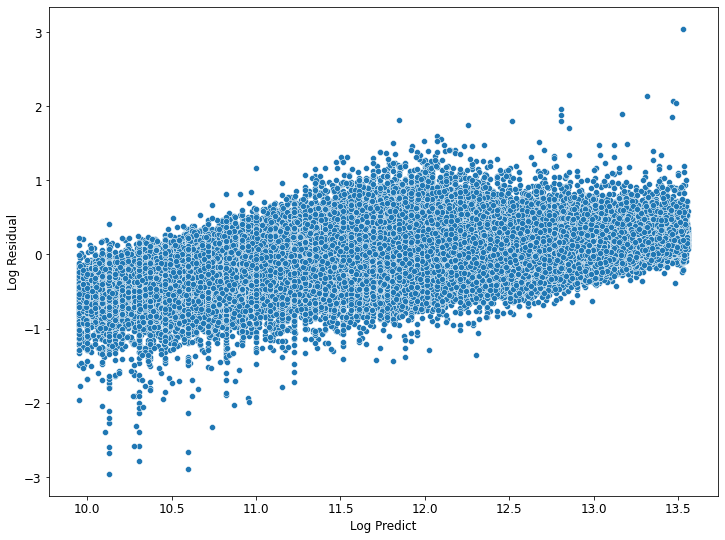

In [ ]:
sns.scatterplot(y_train, y_train-(gm.predict(xgb_X_train) + xgb_pred_all))
plt.xlabel('Log Predict')
plt.ylabel('Log Residual')

#### Xgboost + Ridge

In [ ]:
lm2 = RidgeCV()
Ridge_tr = Normalization(X_tr[['Log Fixed Estimate All']], ['Log Fixed Estimate All'])
Ridge_te = Normalization(X_te[['Log Fixed Estimate All']], ['Log Fixed Estimate All'])
lm2.fit(Ridge_tr, y_tr-xgb_pred_tr)
lm2.alpha_

10.0

In [ ]:
tr_res_pred = lm2.predict(Ridge_tr)
te_res_pred = lm2.predict(Ridge_te)
all_res_pred = lm2.predict(Normalization(xgb_X_train[['Log Fixed Estimate All']], ['Log Fixed Estimate All']))

In [ ]:
ridge_Err_r = np.sqrt(metrics.mean_squared_error(np.exp(tr_res_pred + xgb_pred_tr), np.exp(y_tr)))
ridge_Err_e = np.sqrt(metrics.mean_squared_error(np.exp(te_res_pred + xgb_pred_te), np.exp(y_te)))
ridge_Err_r, ridge_Err_e

(58760.238043240926, 65875.31781970289)

In [ ]:
ridge_Err_o = np.sqrt(metrics.mean_squared_error(np.exp(all_res_pred + xgb_pred_all), np.exp(y_train)))
ridge_Err_o

59510.06208872024

Text(0, 0.5, 'Log Residual')

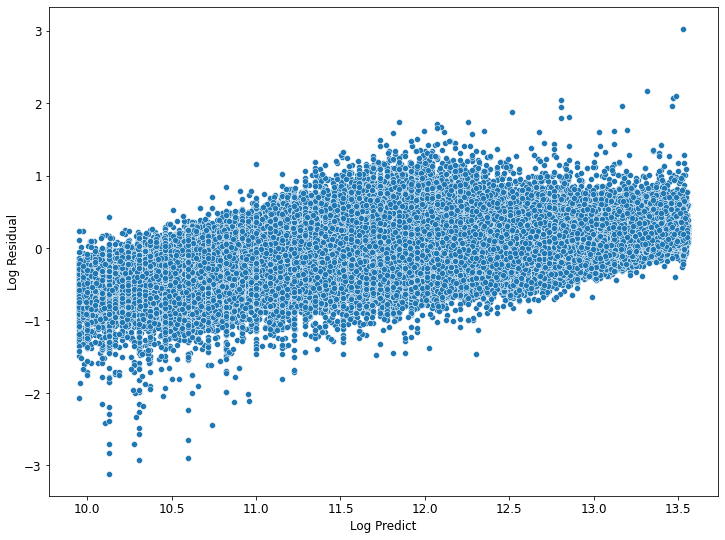

In [ ]:
sns.scatterplot(y_train, y_train-(all_res_pred + xgb_pred_all))
plt.xlabel('Log Predict')
plt.ylabel('Log Residual')

### Summary

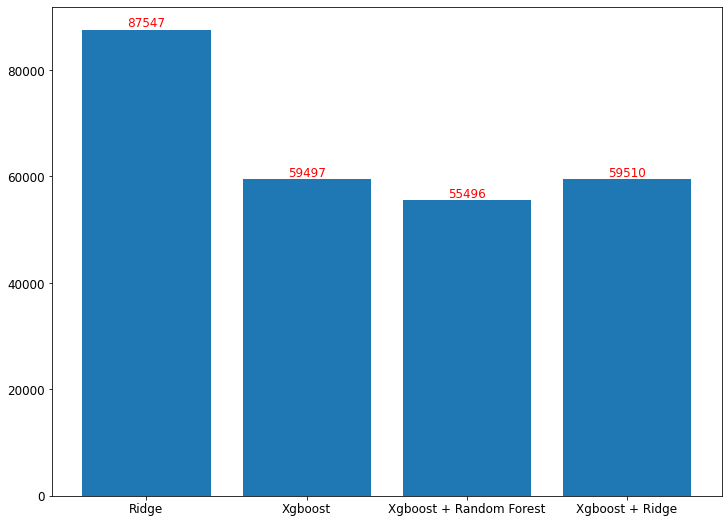

In [ ]:
model_type =['Ridge', 'Xgboost', 'Xgboost + Random Forest', 'Xgboost + Ridge']
model_error = [Err_o, xgb_Err_o, for_Err_o, ridge_Err_o]
plt.bar(x=model_type, height=model_error)
for a, b in zip(model_type, model_error):
    plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=12,color='red')
plt.show()

#### Fit All !!!

In [ ]:
xgb_model.fit(X_tr, y_tr, eval_metric='rmse', eval_set=[(X_te, y_te)], 
          early_stopping_rounds=20, 
          verbose=1);

[0]	validation_0-rmse:9.33057
[1]	validation_0-rmse:7.46885
[2]	validation_0-rmse:5.98050
[3]	validation_0-rmse:4.79056
[4]	validation_0-rmse:3.83988
[5]	validation_0-rmse:3.08103
[6]	validation_0-rmse:2.47611
[7]	validation_0-rmse:1.99477
[8]	validation_0-rmse:1.61264
[9]	validation_0-rmse:1.31040
[10]	validation_0-rmse:1.07287
[11]	validation_0-rmse:0.88757
[12]	validation_0-rmse:0.74462
[13]	validation_0-rmse:0.63623
[14]	validation_0-rmse:0.55529
[15]	validation_0-rmse:0.49592
[16]	validation_0-rmse:0.45320
[17]	validation_0-rmse:0.42309
[18]	validation_0-rmse:0.40173
[19]	validation_0-rmse:0.38796
[20]	validation_0-rmse:0.37848
[21]	validation_0-rmse:0.37194
[22]	validation_0-rmse:0.36717
[23]	validation_0-rmse:0.36377
[24]	validation_0-rmse:0.36138
[25]	validation_0-rmse:0.35934
[26]	validation_0-rmse:0.35806
[27]	validation_0-rmse:0.35699
[28]	validation_0-rmse:0.35519
[29]	validation_0-rmse:0.35432
[30]	validation_0-rmse:0.35384
[31]	validation_0-rmse:0.35325
[32]	validation_0-

In [ ]:
xgb_all = xgb_model.predict(xgb_X_train)
for_Err_all = np.sqrt(metrics.mean_squared_error(np.exp(xgb_all), np.exp(y_train)))
for_Err_all

58730.96555336858

In [ ]:
gm.fit(xgb_X_train, y_train-xgb_all)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  2.6min finished


RandomForestRegressor(max_features='log2', min_samples_leaf=20,
                      n_estimators=120, oob_score=True, random_state=37,
                      verbose=1)

In [ ]:
for_Err = np.sqrt(metrics.mean_squared_error(np.exp(xgb_all + gm.predict(xgb_X_train)), np.exp(y_train)))
for_Err

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    9.0s finished


54238.920691792104

### Final Error:

In [ ]:
for_Err

54238.920691792104

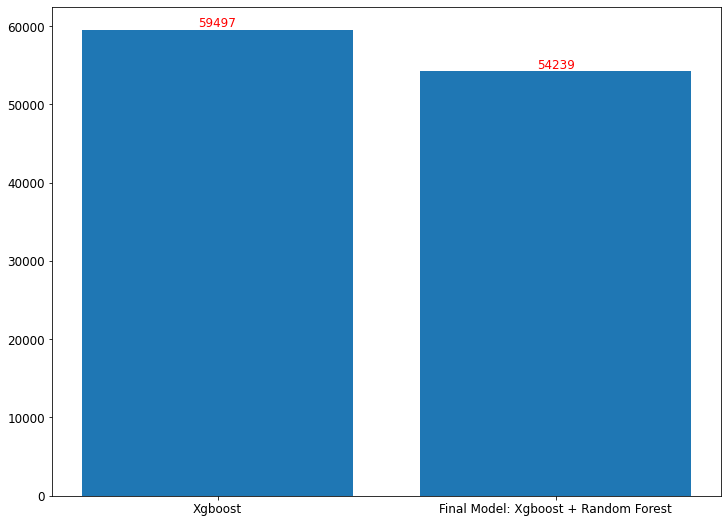

In [ ]:
plt.bar(x=['Xgboost', 'Final Model: Xgboost + Random Forest'], height=[xgb_Err_o, for_Err])
for a, b in zip(['Xgboost', 'Final Model: Xgboost + Random Forest'], [xgb_Err_o, for_Err]):
    plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=12,color='red')
plt.show()

## Step 4. Make Predictions on the Test Dataset

Run the following cell to estimate the sale price on the test dataset and export your model's predictions as a csv file called `predictions.csv`.

In [ ]:
test_data = pd.read_csv('cook_county_contest_test.csv', index_col='Unnamed: 0')
X_test = process_data_fm(test_data).loc[:, X_tr_xgb.columns]
y_test_predicted = np.exp(xgb_model.predict(X_test) + gm.predict(X_test))
predictions = pd.DataFrame({'Sale Price': y_test_predicted})
predictions.to_csv('predictions.csv')
print('Your predictions have been exported as predictions.csv. Please download the file and submit it to Canvas. ')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Your predictions have been exported as predictions.csv. Please download the file and submit it to Canvas. 


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    2.8s finished
